# Lab 3 Test-Time Scaling with transformers

# Part 1. Text-to-image test time scaling

In this part, we study test-time scaling for autoregressive (AR) text-to-image (T2I) models.
The model parameters are frozen. All improvements must come only from inference-time computation.

We will use an AR image-token generator to explore test-time scaling and evaluate the results based on:

-	image quality
-	prompt alignment
-   diversity

<!-- In this part, we will focus on test time scaling with AR t2i model -->

**Learning Objectives**

By the end of this lab, students should be able to:

	1.	Implement autoregressive image generation correctly
	2.	Understand and evaluate Best-of-N (BoN) as a test-time scaling method
	3.	Reason about how hyperparameters such as sampling temperature and CFG affect distributions
	4.	Compare multiple reward functions and analyze their correlation
	5.	Understand limitations of BoN and motivate more advanced test-time algorithms

### **Question 1.1** (Warm-up)

Complete the inference loop for an autoregressive T2I model.

At each inference step:

	1.	Compute next-token logits conditioned on previous tokens
	2.	Sample the next token
	3.	Append it to the sequence
	4.	Repeat until the full image token sequence is generated


Hints

-   Familiar with the model input and output
-	Pay attention to tensor shapes and caching
-	Sampling should be stochastic (not argmax)


In [1]:
# %% load janus-pro

# !git clone https://huggingface.co/deepseek-ai/Janus-Pro-7B
!git clone https://github.com/deepseek-ai/Janus.git
# !pip install torch==2.2.1 torchvision==0.17.1 torchaudio==2.2.1
!pip install torch==2.9.1 torchvision==0.24.1 torchaudio==2.9.1
# !pip install transformers==4.38.2
!pip install transformers==4.41.2
!pip install timm>=0.9.16
!pip install accelerate
!pip install sentencepiece
!pip install attrdict
!pip install einops
!pip install timm
# !pip install bitsandbytes==0.49.1

# !cd Janus

Cloning into 'Janus'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 121 (delta 58), reused 38 (delta 38), pack-reused 37 (from 1)
Receiving objects: 100% (121/121), 7.18 MiB | 32.98 MiB/s, done.
Resolving deltas: 100% (59/59), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 50.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 47.9 MB/s  0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.2
    Uninstalling tokenizers-0.22.2:
      Successfully uninstalled tokenizers-0.22.2
  Attempting uninstall: transformers━━━━━━━━━━━━ 0/2 [tokenizers]
    Found existing installation: transformers 4.57.62m0/2 [tokenizers]
    Uninstalling transformers-4.57.6:╺━━━━━━━━━━━━━━━━━━━ 1/2 [transformers]
      Successfully uninstalled transformers-4.57.6━━━━━━━━━━━━━━━━ 1/2 [transformers]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import os
import PIL.Image
import torch
import numpy as np
from transformers import AutoModelForCausalLM
from Janus.janus.models import MultiModalityCausalLM, VLChatProcessor
import tqdm
import matplotlib.pyplot as plt

### load Janus-Pro 1B
model_path = "deepseek-ai/Janus-Pro-1B"
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path, trust_remote_code=True
)
vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()

torch.cuda.empty_cache()

/users/eleves-a/2023/baptiste.arnaudo/CSC_52002_EP-MultimodalGenAI/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python version is above 3.10, patching the collections module.
Python version is above 3.10, patching the collections module.


You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [2]:
@torch.inference_mode()
def generate_image(
    mmgpt: MultiModalityCausalLM,
    vl_chat_processor: VLChatProcessor,
    user_prompt: str,
    temperature: float = 1,
    num_images_per_prompt: int = 4,
    cfg_weight: float = 5,
    # fixed
    image_token_num_per_image: int = 576,
    img_size: int = 384,
    patch_size: int = 16,
):
    # apply SFT format and system prompt
    conversation = [
        {
            "role": "<|User|>",
            "content": user_prompt,
        },
        {"role": "<|Assistant|>", "content": ""},
    ]
    sft_format = vl_chat_processor.apply_sft_template_for_multi_turn_prompts(
        conversations=conversation,
        sft_format=vl_chat_processor.sft_format,
        system_prompt="",
    )
    prompt = sft_format + vl_chat_processor.image_start_tag

    # preprocess the prompts
    input_ids = vl_chat_processor.tokenizer.encode(prompt)
    input_ids = torch.LongTensor(input_ids)

    ### here we assume CFG is used, so we need to duplicate the input_ids for cond and uncond
    tokens = torch.zeros((num_images_per_prompt*2, len(input_ids)), dtype=torch.int).cuda()
    for i in range(num_images_per_prompt*2):
        tokens[i, :] = input_ids
        if i % 2 != 0:
            tokens[i, 1:-1] = vl_chat_processor.pad_id

    inputs_embeds = mmgpt.language_model.get_input_embeddings()(tokens)

    generated_tokens = torch.zeros((num_images_per_prompt, image_token_num_per_image), dtype=torch.int).cuda()

    # inference loop
    ######## STUDENT_ANSWER_START ########
    ### for CFG, we can inference cond and uncond together, batch size wise; or we can inference one by one

    for i in range(image_token_num_per_image):
        # get logits
        outputs = mmgpt.language_model.model(
            inputs_embeds=inputs_embeds,
            use_cache=True,
            past_key_values=outputs.past_key_values if i != 0 else None
        )
        hidden_states = outputs.last_hidden_state  # [B, seq_len, embed_dim]
        
        logits = mmgpt.gen_head(hidden_states[:, -1, :])

        # split cond and uncond
        cond_logits = logits[0::2, :]  # [num_images_per_prompt, vocab_size]
        uncond_logits = logits[1::2, :]  # [num_images_per_prompt, vocab_size]
        # apply CFG
        final_logits = uncond_logits + cfg_weight * (cond_logits - uncond_logits)  # [num_images_per_prompt, vocab_size]

        # apply temperature
        final_logits = final_logits / temperature

        # sample next token
        probs = torch.softmax(final_logits, dim=-1)  # [num_images_per_prompt, vocab_size]
        next_tokens = torch.multinomial(probs, num_samples=1).squeeze(-1)  # [num_images_per_prompt]

        # store generated tokens
        generated_tokens[:, i] = next_tokens.squeeze(dim=-1)

        next_token_expanded = torch.cat([next_tokens.unsqueeze(dim=1), next_tokens.unsqueeze(dim=1)], dim=1).view(-1)
        img_embeds = mmgpt.prepare_gen_img_embeds(next_token_expanded)
        inputs_embeds = img_embeds.unsqueeze(dim=1)


    ######## STUDENT_ANSWER_END ########

    assert generated_tokens.shape == (num_images_per_prompt, image_token_num_per_image)

    # decode image tokens
    dec = mmgpt.gen_vision_model.decode_code(generated_tokens.to(dtype=torch.int), shape=[num_images_per_prompt, 8, img_size//patch_size, img_size//patch_size])
    dec = dec.to(torch.float32).cpu()   # [B, C, H, W] [-1,1]

    # convert to pil images
    dec = dec.numpy().transpose(0, 2, 3, 1)
    dec = np.clip((dec + 1) / 2 * 255, 0, 255)
    visual_img = np.zeros((num_images_per_prompt, img_size, img_size, 3), dtype=np.uint8)
    visual_img[:, :, :] = dec

    # store images in a list
    image_list = []
    for i in range(num_images_per_prompt):
        image_list.append(PIL.Image.fromarray(visual_img[i]))

    return image_list

In [12]:
### test the image generation function, choose freely your favorite prompt
# user_prompt = "A photo of a realistic but impossible object."
user_prompt = "A photo of a croissant."
# user_prompt = "A cat holding a plate with the word 'CAT' written in large letters."
# user_prompt = "A green apple on the left of two red apple, both on a white plate, studio lighting."

num_images_per_prompt = 4
save_dir = "./generated_samples_test"
os.makedirs(save_dir, exist_ok=True)

image_list = generate_image(
    vl_gpt,
    vl_chat_processor,
    user_prompt,
    num_images_per_prompt=num_images_per_prompt
)

for i in range(num_images_per_prompt):
    save_path = os.path.join(save_dir, "img_{}.jpg".format(i))
    image_list[i].save(save_path)

### **Question 1.2**

Explore Best-of-N (BoN) Scaling

Task

For each of 2-3 prompts:

	1.	Generate N independent samples using the same prompt
	2.	Compute the reward for each sample
	3.	Select the sample with the highest reward (Best-of-N)

Run this experiment for increasing values of N.

Plot one curve per prompt (Best reward vs. number of N), and the average.

Analysis questions

	1.	Does the improvement saturate? Why?
	2.	Is the improvement logarithmic, linear, or diminishing?

In [4]:
from transformers import CLIPProcessor, CLIPModel
from typing import List, Optional, Dict, Any, Tuple

# -----------------------------
# CLIP reranker (best-of-N)
# -----------------------------
class ClipReranker:
    def __init__(self, model_name: str = "openai/clip-vit-base-patch32"):
        self.clip_model = CLIPModel.from_pretrained(model_name).cuda().eval()
        self.clip_proc = CLIPProcessor.from_pretrained(model_name)

    @torch.inference_mode()
    def score(self, prompt_text: str, images: List[PIL.Image.Image]) -> torch.Tensor:
        inputs = self.clip_proc(
            text=[prompt_text] * len(images),
            images=images,
            return_tensors="pt",
            padding=True,
        )
        inputs = inputs.to(self.clip_model.device)
        out = self.clip_model(**inputs)
        # calculate cosine similarity
        img = out.image_embeds / out.image_embeds.norm(dim=-1, keepdim=True)
        txt = out.text_embeds / out.text_embeds.norm(dim=-1, keepdim=True)
        sim = (img * txt).sum(dim=-1)
        return sim.detach().cpu()

    def select_best(self, prompt_text: str, images: List[PIL.Image.Image]) -> Tuple[int, float, torch.Tensor]:
        scores = self.score(prompt_text, images)
        best_i = int(scores.argmax().item())
        best_s = float(scores[best_i].item())
        return best_i, best_s, scores

# initialize the CLIP reranker
clip_reranker = ClipReranker()

You need to generate multiple images per prompt.
For each prompt, generate N = num_images_per_prompt * num_batches images, and compute the reward for each image.
Then, for each prompt, group the images into num_batches groups of size num_images_per_prompt, and select the best image from each group.
Compute the average reward of the selected images for each prompt.
Then compute the average reward across all prompts for the current N.

In [ ]:
# With all due respect, the question is incomprehensible

prompt_list = [
    "A photo of a realistic but impossible object.",
    "A photo of a croissant.",
    "A cat holding a plate with the word 'CAT' written in large letters.",
    "A green apple on the left of two red apple, both on a white plate, studio lighting.",
]

save_dir = "generated_samples_BoN_CLIP"
os.makedirs(save_dir, exist_ok=True)

# # total 64 images per prompt
# num_batches = 16
# num_images_per_prompt = 4

######## STUDENT_ANSWER_START ########

num_batches = [1, 2, 4, 8, 12, 16, 20, 24, 28, 32]
num_images_per_prompt = [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
N_list = [n*b for n, b in zip(num_images_per_prompt, num_batches)]

def experience(num_batches, num_images_per_prompt,prompt_list):

    N = num_batches * num_images_per_prompt
    print(f"Generating N={N} images per prompt with CLIP best-of-N reranking...")
    print("-"*50)
    avg_reward_of_selected_img_per_prompt = []
    best_reward_of_selected_img_per_prompt = []

    for prompt in prompt_list:
        print(f"Processing prompt: {prompt}")

        selected_images_and_scores = []
        for _ in range(num_batches):
            images = generate_image(
                vl_gpt,
                vl_chat_processor,
                prompt,
                num_images_per_prompt=num_images_per_prompt
            )
            best_i, best_s, _ = clip_reranker.select_best(prompt, images)
            best_image = images[best_i]
            selected_images_and_scores.append((best_image, best_s))
        avg_reward_of_selected_img_per_prompt.append(np.mean([s for _, s in selected_images_and_scores]))
        print(f"Average CLIP score of selected images for this prompt: {avg_reward_of_selected_img_per_prompt[-1]:.4f}")
        # save best image for this prompt
        best_image_overall, best_score_overall = max(selected_images_and_scores, key=lambda x: x[1])
        save_path = os.path.join(save_dir, f"best_img_prompt_{prompt_list.index(prompt)}.jpg")
        best_image_overall.save(save_path)
        best_reward_of_selected_img_per_prompt.append(best_score_overall)
        print(f"Best CLIP score of selected images for this prompt: {best_reward_of_selected_img_per_prompt[-1]:.4f}")
        print("-"*50)

    avg_reward_across_prompts = np.mean(best_reward_of_selected_img_per_prompt) # from what I understand this is what is asked but it is not really clear
    print(f"Average CLIP score of selected images across all prompts: {avg_reward_across_prompts:.4f}")
    print("-"*50)
    print("-"*50)
    return avg_reward_across_prompts, avg_reward_of_selected_img_per_prompt, best_reward_of_selected_img_per_prompt
######## STUDENT_ANSWER_END ########

avg_rewards_per_prompt = {prompt: [] for prompt in prompt_list}
best_rewards_per_prompt = {prompt: [] for prompt in prompt_list}
list_avg_rewards_across_prompts = []
for (num_batches, num_images_per_prompt) in zip(num_batches, num_images_per_prompt):
    avg_reward_across_prompts, avg_reward_of_selected_img_per_prompt, best_reward_of_selected_img_per_prompt = experience(num_batches, num_images_per_prompt, prompt_list)
    list_avg_rewards_across_prompts.append(avg_reward_across_prompts)

    for i, prompt in enumerate(prompt_list):
        avg_rewards_per_prompt[prompt].append(avg_reward_of_selected_img_per_prompt[i])
        best_rewards_per_prompt[prompt].append(best_reward_of_selected_img_per_prompt[i])

Generating N=4 images per prompt with CLIP best-of-N reranking...
--------------------------------------------------
Processing prompt: A photo of a realistic but impossible object.
Average CLIP score of selected images for this prompt: 0.2865
Best CLIP score of selected images for this prompt: 0.2865
--------------------------------------------------
Processing prompt: A photo of a croissant.
Average CLIP score of selected images for this prompt: 0.3591
Best CLIP score of selected images for this prompt: 0.3591
--------------------------------------------------
Processing prompt: A cat holding a plate with the word 'CAT' written in large letters.
Average CLIP score of selected images for this prompt: 0.3572
Best CLIP score of selected images for this prompt: 0.3572
--------------------------------------------------
Processing prompt: A green apple on the left of two red apple, both on a white plate, studio lighting.
Average CLIP score of selected images for this prompt: 0.3465
Best CL

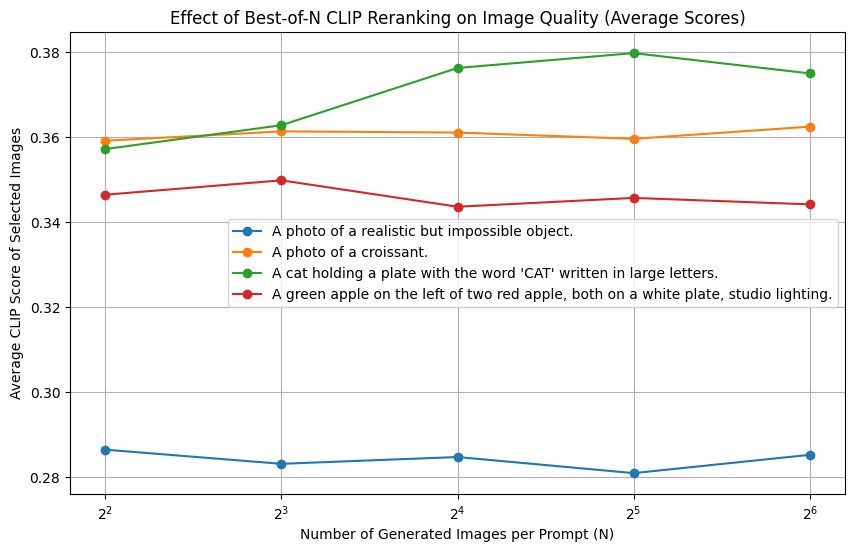

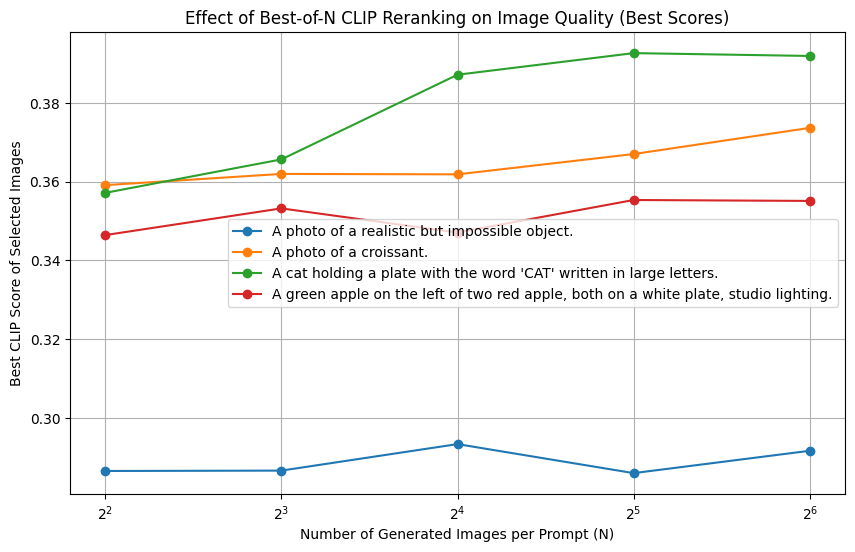

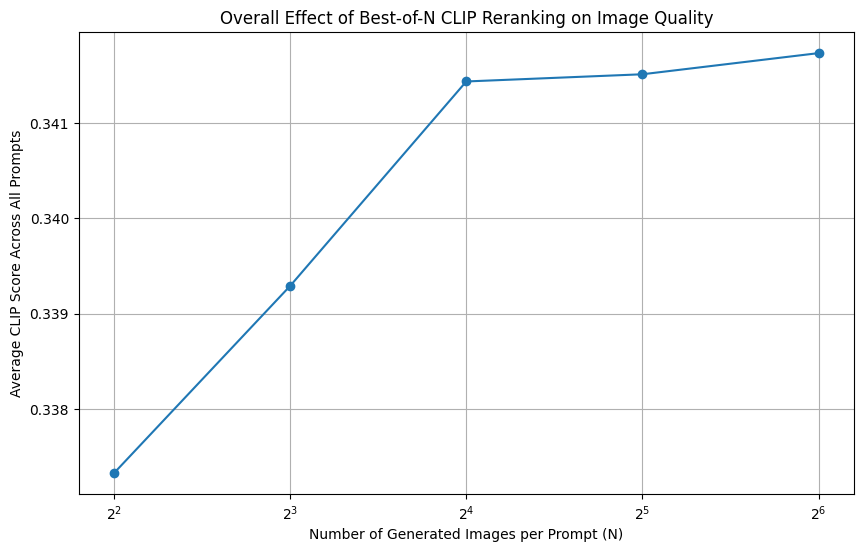

In [6]:
# Plotting the results
plt.figure(figsize=(10, 6))
for prompt in prompt_list:
    plt.plot(N_list, avg_rewards_per_prompt[prompt], marker='o', label=prompt)
plt.xscale('log', base=2)
plt.xlabel('Number of Generated Images per Prompt (N)')
plt.ylabel('Average CLIP Score of Selected Images')
plt.title('Effect of Best-of-N CLIP Reranking on Image Quality (Average Scores)')
plt.legend()
plt.grid(True)
plt.savefig('clip_reranking_effect_avg.png')

plt.figure(figsize=(10, 6))
for prompt in prompt_list:
    plt.plot(N_list, best_rewards_per_prompt[prompt], marker='o', label=prompt)
plt.xscale('log', base=2)
plt.xlabel('Number of Generated Images per Prompt (N)')
plt.ylabel('Best CLIP Score of Selected Images')
plt.title('Effect of Best-of-N CLIP Reranking on Image Quality (Best Scores)')
plt.legend()
plt.grid(True)
plt.savefig('clip_reranking_effect_best.png')

plt.figure(figsize=(10, 6))
plt.plot(N_list, list_avg_rewards_across_prompts, marker='o')
plt.xscale('log', base=2)
plt.xlabel('Number of Generated Images per Prompt (N)')
plt.ylabel('Average CLIP Score Across All Prompts')
plt.title('Overall Effect of Best-of-N CLIP Reranking on Image Quality')
plt.grid(True)
plt.savefig('clip_reranking_effect_overall.png')

### **Question 1.3** Sampling Hyperparameters


**Repeat** Question 1.2 while varying the sampling temperature T:
T \in \{0.7, 1.0, 1.3\}

Visualizations

-	Image grids for each temperature
-	Best-of-N reward curves at different temperatures

Analysis questions

	1.	How does temperature affect diversity?
	2.	For which temperatures does BoN help the most?


#### Bonus: classifier free guidance (CFG)

What is CFG in AR models, how does it change the sampling behavior of the models.

##### Introduction to CFG
Classifier-Free Guidance (CFG) is a conditional sampling method that combines a model’s conditional and unconditional predictions to amplify the influence of the condition at decoding time, without training a separate classifier. For an autoregressive model, we compute conditional logits $\ell_{\text{cond}}$ (given condition c) and unconditional logits $\ell_{\text{uncond}}$ (with the condition removed). We then form guided logits $\ell_{\text{cfg}} = \ell_{\text{uncond}} + s(\ell_{\text{cond}}-\ell_{\text{uncond}})$, where $s$ is the guidance scale. Sampling from $\text{softmax}(\ell_{\text{cfg}}/T)$ increases the probability of tokens that are more consistent with the condition. Increasing $s$ typically improves condition adherence and can increase reward when the reward aligns with the condition, but it often reduces diversity and can cause overconfident or repetitive outputs if set too high.

CFG was originally invented for diffusion models, but is widely used for AR visual generation, see https://sander.ai/2022/05/26/guidance.html


In [ ]:
### try temperature 0.7

prompt_list = [
    "A photo of a realistic but impossible object.",
    "A photo of a croissant.",
    "A cat holding a plate with the word 'CAT' written in large letters.",
    "A green apple on the left of two red apple, both on a white plate, studio lighting.",
]

save_dir = "generated_samples_BoN_CLIP_temp07"
os.makedirs(save_dir, exist_ok=True)

######## STUDENT_ANSWER_START ########

clip_BoN_list_temp07 = []
clip_scores_list_temp07 = []

num_batches = [1, 2, 4, 8, 12, 16, 20, 24, 28, 32]
num_images_per_prompt = [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
# num_batches = [1]
# num_images_per_prompt = [4]
N_list = [n*b for n, b in zip(num_images_per_prompt, num_batches)]

for (batch, images_per_prompt) in zip(num_batches, num_images_per_prompt):
    N = batch * images_per_prompt
    print(f"Generating N={N} images per prompt with CLIP best-of-N reranking at temperature 0.7...")
    print("-"*50)
    for prompt in prompt_list:
        print(f"Processing prompt: {prompt}")

        selected_images_and_scores = []
        for b in range(batch):
            images = generate_image(
                vl_gpt,
                vl_chat_processor,
                prompt,
                num_images_per_prompt=images_per_prompt,
                temperature=0.7
            )
            best_i, best_s, scores = clip_reranker.select_best(prompt, images)
            best_image = images[best_i]
            save_path = os.path.join(save_dir, f"best_img_prompt_{prompt_list.index(prompt)}_temp07.jpg")
            best_image.save(save_path)
            selected_images_and_scores.append((best_image, best_s))
            clip_scores_list_temp07.extend(scores.numpy().tolist())
        # store best score for this N
        best_score_overall = max([s for _, s in selected_images_and_scores])
        clip_BoN_list_temp07.append(best_score_overall)
        print(f"Best CLIP score of selected images for this prompt: {best_score_overall:.4f}")
        print("-"*50)

avg_rewards_per_prompt = {prompt: [] for prompt in prompt_list}
best_rewards_per_prompt = {prompt: [] for prompt in prompt_list}
for (num_batches, num_images_per_prompt) in zip(num_batches, num_images_per_prompt):
    for i in range(0, len(clip_BoN_list_temp07), 4):
        for j in range(4):
            prompt = prompt_list[j]
            best_reward = clip_BoN_list_temp07[i + j]
            best_rewards_per_prompt[prompt].append(best_reward)
            avg_rewards_per_prompt[prompt].append(np.mean(clip_scores_list_temp07[i + j:i + j + num_batches]))

######## STUDENT_ANSWER_END ########

Generating N=4 images per prompt with CLIP best-of-N reranking at temperature 0.7...
--------------------------------------------------
Processing prompt: A photo of a realistic but impossible object.
Best CLIP score of selected images for this prompt: 0.2878
--------------------------------------------------
Processing prompt: A photo of a croissant.
Best CLIP score of selected images for this prompt: 0.3528
--------------------------------------------------
Processing prompt: A cat holding a plate with the word 'CAT' written in large letters.
Best CLIP score of selected images for this prompt: 0.3693
--------------------------------------------------
Processing prompt: A green apple on the left of two red apple, both on a white plate, studio lighting.
Best CLIP score of selected images for this prompt: 0.3548
--------------------------------------------------


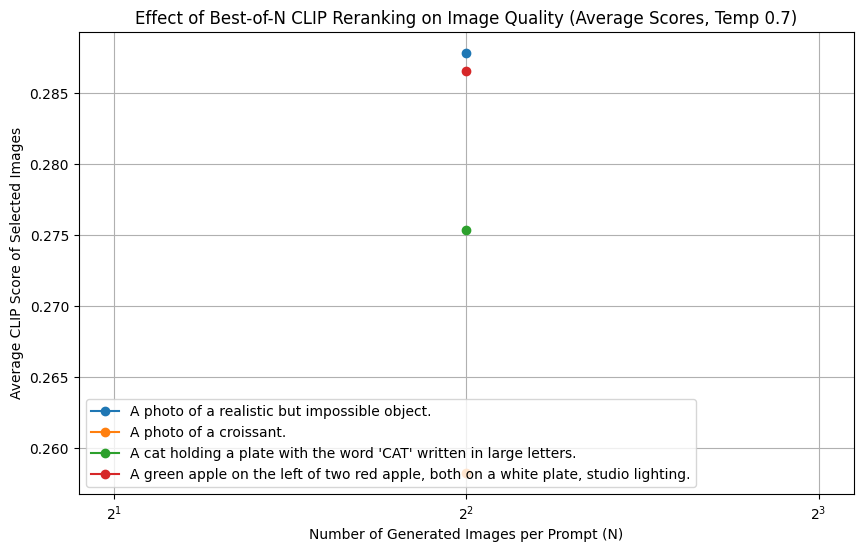

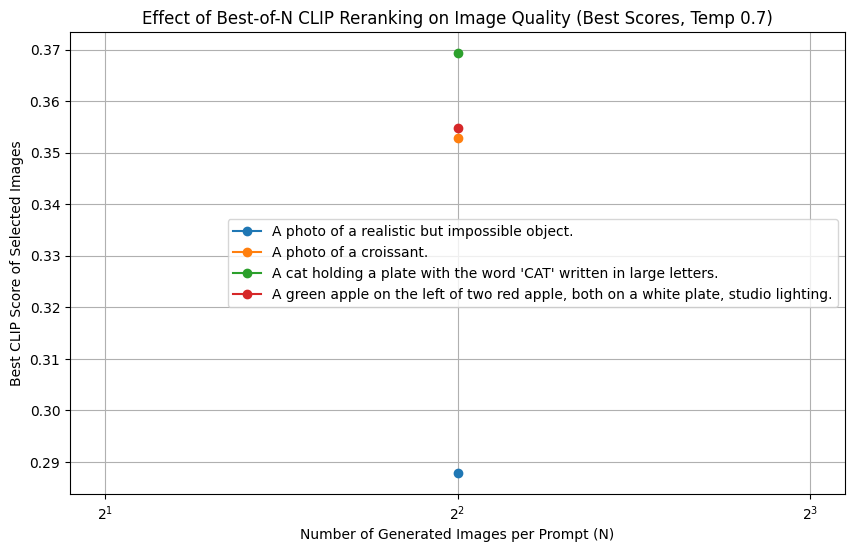

In [14]:
# Plotting the results
plt.figure(figsize=(10, 6))
for prompt in prompt_list:
    plt.plot(N_list, avg_rewards_per_prompt[prompt], marker='o', label=prompt)
plt.xscale('log', base=2)
plt.xlabel('Number of Generated Images per Prompt (N)')
plt.ylabel('Average CLIP Score of Selected Images')
plt.title('Effect of Best-of-N CLIP Reranking on Image Quality (Average Scores, Temp 0.7)')
plt.legend()
plt.grid(True)
plt.savefig('clip_reranking_effect_avg.png')

plt.figure(figsize=(10, 6))
for prompt in prompt_list:
    plt.plot(N_list, best_rewards_per_prompt[prompt], marker='o', label=prompt)
plt.xscale('log', base=2)
plt.xlabel('Number of Generated Images per Prompt (N)')
plt.ylabel('Best CLIP Score of Selected Images')
plt.title('Effect of Best-of-N CLIP Reranking on Image Quality (Best Scores, Temp 0.7)')
plt.legend()
plt.grid(True)
plt.savefig('clip_reranking_effect_best.png')

In [ ]:
# ### try temperature 1.5 (optional)
save_dir = "generated_samples_BoN_CLIP_temp15"
os.makedirs(save_dir, exist_ok=True)


######## STUDENT_ANSWER_START ########




######## STUDENT_ANSWER_END ########

# plot CLIP BoN scores
plt.figure(figsize=(8, 5))
plt.plot(N_list, clip_BoN_list_temp15, marker='o')
plt.xscale('log', base=2)
plt.xlabel('Number of Samples (N)')
plt.ylabel('Best CLIP Score')
plt.title('CLIP Best-of-N Scores vs Number of Samples')
plt.grid(True)
plt.savefig(os.path.join(save_dir, 'clip_bon_scores.png'))

# plot the histogram of CLIP scores
plt.figure(figsize=(8, 5))
plt.hist(clip_scores_list_temp15, bins=30, alpha=0.7, color='blue')
plt.xlabel('CLIP Score')
plt.ylabel('Number of Images')
plt.title('Histogram of CLIP Scores for Generated Images')
plt.savefig(os.path.join(save_dir, 'clip_scores_histogram.png'))

What if the temperature is very small?

In [ ]:
# ### try extreme temperature 0.0001, remembner that very low temperature to approach greedy decoding, can confirm that via generated images (optional)
save_dir = "generated_samples_BoN_CLIP_temp0001"
os.makedirs(save_dir, exist_ok=True)


######## STUDENT_ANSWER_START ########




######## STUDENT_ANSWER_END ########

# plot CLIP BoN scores
plt.figure(figsize=(8, 5))
plt.plot(N_list, clip_BoN_list_temp01, marker='o')
plt.xscale('log', base=2)
plt.xlabel('Number of Samples (N)')
plt.ylabel('Best CLIP Score')
plt.title('CLIP Best-of-N Scores vs Number of Samples')
plt.grid(True)
plt.savefig(os.path.join(save_dir, 'clip_bon_scores.png'))

# plot the histogram of CLIP scores
plt.figure(figsize=(8, 5))
plt.hist(clip_scores_list_temp01, bins=30, alpha=0.7, color='blue')
plt.xlabel('CLIP Score')
plt.ylabel('Number of Images')
plt.title('Histogram of CLIP Scores for Generated Images')
plt.savefig(os.path.join(save_dir, 'clip_scores_histogram.png'))

In [ ]:
## different CFG scale, explore how cfg scale will affect the results (optional)

save_dir = "generated_samples_BoN_CLIP_cfg1"
os.makedirs(save_dir, exist_ok=True)

######## STUDENT_ANSWER_START ########





######## STUDENT_ANSWER_END ########

# plot CLIP BoN scores
plt.figure(figsize=(8, 5))
plt.plot(N_list, clip_BoN_list_cfg1, marker='o')
plt.xscale('log', base=2)
plt.xlabel('Number of Samples (N)')
plt.ylabel('Best CLIP Score')
plt.title('CLIP Best-of-N Scores vs Number of Samples')
plt.grid(True)
plt.savefig(os.path.join(save_dir, 'clip_bon_scores.png'))

# plot the histogram of CLIP scores
plt.figure(figsize=(8, 5))
plt.hist(clip_scores_list_cfg1, bins=30, alpha=0.7, color='blue')
plt.xlabel('CLIP Score')
plt.ylabel('Number of Images')
plt.title('Histogram of CLIP Scores for Generated Images')
plt.savefig(os.path.join(save_dir, 'clip_scores_histogram.png'))

In [ ]:
## different CFG scale, what happens if we use a very large CFG scale like 10 or 100 (optional)

save_dir = "generated_samples_BoN_CLIP_cfg10"
os.makedirs(save_dir, exist_ok=True)

######## STUDENT_ANSWER_START ########




######## STUDENT_ANSWER_END ########

# plot CLIP BoN scores
plt.figure(figsize=(8, 5))
plt.plot(N_list, clip_BoN_list_cfg10, marker='o')
plt.xscale('log', base=2)
plt.xlabel('Number of Samples (N)')
plt.ylabel('Best CLIP Score')
plt.title('CLIP Best-of-N Scores vs Number of Samples')
plt.grid(True)
plt.savefig(os.path.join(save_dir, 'clip_bon_scores.png'))

# plot the histogram of CLIP scores
plt.figure(figsize=(8, 5))
plt.hist(clip_scores_list_cfg10, bins=30, alpha=0.7, color='blue')
plt.xlabel('CLIP Score')
plt.ylabel('Number of Images')
plt.title('Histogram of CLIP Scores for Generated Images')
plt.savefig(os.path.join(save_dir, 'clip_scores_histogram.png'))

### **Question 1.4** Alternative Rewards

Repeat Question 1.2 using a second reward function, for example:

-	aesthetic score
-	image reward
-	counting (part of GenEval)

Required analysis

	1.	Plot reward₁ vs. reward₂ for all samples
	2.	Show correlation

Discussion questions

	1.	Are the rewards correlated or conflicting?
	2.	Can BoN over-optimize one reward at the expense of another?
	3.	Which reward better matches human judgment?

#### Bonus
Look into the generated data, is your favorate image the same as the one with highest score?

In [18]:
!wget https://github.com/christophschuhmann/improved-aesthetic-predictor/raw/refs/heads/main/sac+logos+ava1-l14-linearMSE.pth

--2026-01-26 09:45:12--  https://github.com/christophschuhmann/improved-aesthetic-predictor/raw/refs/heads/main/sac+logos+ava1-l14-linearMSE.pth
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


302 Found
Location: https://raw.githubusercontent.com/christophschuhmann/improved-aesthetic-predictor/refs/heads/main/sac%2Blogos%2Bava1-l14-linearMSE.pth [following]
--2026-01-26 09:45:12--  https://raw.githubusercontent.com/christophschuhmann/improved-aesthetic-predictor/refs/heads/main/sac%2Blogos%2Bava1-l14-linearMSE.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3714759 (3.5M) [application/octet-stream]
Saving to: ‘sac+logos+ava1-l14-linearMSE.pth’

sac+logos+ava1-l14- 100%[===================>]   3.54M  --.-KB/s    in 0.07s   

2026-01-26 09:45:13 (51.2 MB/s) - ‘sac+logos+ava1-l14-linearMSE.pth’ saved [3714759/3714759]



In [5]:
# -----------------------------
# aesthetic score model
# -----------------------------

from transformers import AutoProcessor, AutoModelForImageClassification
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(768, 1024),
            nn.Dropout(0.2),
            nn.Linear(1024, 128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.Dropout(0.1),
            nn.Linear(64, 16),
            nn.Linear(16, 1),
        )
    @torch.no_grad()
    def forward(self, embed):
        return self.layers(embed)


class AestheticScorer(torch.nn.Module):
    def __init__(self, dtype, device):
        super().__init__()
        self.clip = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
        self.mlp = MLP().to(device)
        state_dict = torch.load("sac+logos+ava1-l14-linearMSE.pth", map_location="cpu")
        self.mlp.load_state_dict(state_dict)
        self.dtype = dtype
        self.device = device
        self.eval()

    @torch.no_grad()
    def __call__(self, images):
        inputs = self.processor(images=images, return_tensors="pt")
        inputs = {k: v.to(self.dtype).to(self.device) for k, v in inputs.items()}
        embed = self.clip.get_image_features(**inputs)
        # normalize embedding
        embed = embed / torch.linalg.vector_norm(embed, dim=-1, keepdim=True)
        return self.mlp(embed).squeeze(1)

aesthetic_scorer = AestheticScorer(dtype=torch.float16, device="cuda")

In [6]:
## calculate aesthetic scores for all images generated and stored before

save_dir = "generated_samples_BoN_aesthetic"
os.makedirs(save_dir, exist_ok=True)

######## STUDENT_ANSWER_START ########
prompt_list = [
    "A photo of a realistic but impossible object.",
    "A photo of a croissant.",
    "A cat holding a plate with the word 'CAT' written in large letters.",
    "A green apple on the left of two red apple, both on a white plate, studio lighting.",
]

aesthetic_BoN_list = []
aesthetic_scores_list = []
# num_batches = [1, 2, 4, 8, 12, 16, 20, 24, 28, 32]
# num_images_per_prompt = [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
num_batches = [1]
num_images_per_prompt = [4]
N_list = [n*b for n, b in zip(num_images_per_prompt, num_batches)]
for (batch, images_per_prompt) in zip(num_batches, num_images_per_prompt):
    N = batch * images_per_prompt
    print(f"Generating N={N} images per prompt with aesthetic best-of-N reranking...")
    print("-"*50)
    for prompt in prompt_list:
        print(f"Processing prompt: {prompt}")

        selected_images_and_scores = []
        for b in range(batch):
            images = generate_image(
                vl_gpt,
                vl_chat_processor,
                prompt,
                num_images_per_prompt=images_per_prompt,
            )
            scores = aesthetic_scorer(images).cpu()
            best_i = int(scores.argmax().item())
            best_s = float(scores[best_i].item())
            best_image = images[best_i]
            save_path = os.path.join(save_dir, f"best_img_prompt_{prompt_list.index(prompt)}_aesthetic.jpg")
            best_image.save(save_path)
            selected_images_and_scores.append((best_image, best_s))
            aesthetic_scores_list.extend(scores.numpy().tolist())
        # store best score for this N
        best_score_overall = max([s for _, s in selected_images_and_scores])
        aesthetic_BoN_list.append(best_score_overall)
        print(f"Best Aesthetic score of selected images for this prompt: {best_score_overall:.4f}")
        print("-"*50)

avg_rewards_per_prompt = {prompt: [] for prompt in prompt_list}
best_rewards_per_prompt = {prompt: [] for prompt in prompt_list}
for (num_batches, num_images_per_prompt) in zip(num_batches, num_images_per_prompt):
    for i in range(0, len(aesthetic_BoN_list), 4):
        for j in range(4):
            prompt = prompt_list[j]
            best_reward = aesthetic_BoN_list[i + j]
            best_rewards_per_prompt[prompt].append(best_reward)
            avg_rewards_per_prompt[prompt].append(np.mean(aesthetic_scores_list[i + j:i + j + num_batches]))

######## STUDENT_ANSWER_END ########

Generating N=4 images per prompt with aesthetic best-of-N reranking...
--------------------------------------------------
Processing prompt: A photo of a realistic but impossible object.


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 15.58 GiB of which 4.25 MiB is free. Process 670484 has 784.00 MiB memory in use. Process 989164 has 7.36 GiB memory in use. Including non-PyTorch memory, this process has 7.29 GiB memory in use. Of the allocated memory 6.68 GiB is allocated by PyTorch, and 425.01 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
## plot both rewards against each other, using two y-axis (optional)

######## STUDENT_ANSWER_START ########




######## STUDENT_ANSWER_END ########


### **Question 1.5** Beyond BoN (Open-Ended)

Propose or learn one alternative tts algorithm for AR model that is not Best-of-N.

Describe:

	1.	How it works
	2.	Why it may outperform BoN
	3.	What additional cost it introduces (if any)


Here are some literatures you can chose from:

- https://arxiv.org/abs/2511.21185
- https://arxiv.org/abs/2501.13926
- https://openreview.net/forum?id=EjyCJySMrD

####### STUDENT_ANSWER_START ########



####### STUDENT_ANSWER_END ########

### Algorithm description:

### **Question 1.6** TTS vs. RL (Optional)

Read the following paper, try to answer the relationship between TTS and RL

https://arxiv.org/abs/2504.13837

<!-- Explore different prompt engineering techniques. How does varying the prompt structure (e.g., adding descriptive adjectives, specifying styles, using negative prompts) affect the diversity and adherence of the generated images to the user's intent? Provide examples of prompts and the corresponding generated images to illustrate your findings. -->

####### STUDENT_ANSWER_START ########



####### STUDENT_ANSWER_END ########

# Part 2: Test-Time Scaling and Inference Compute for VLMs

In this part, we explore the concept of **Inference-Time Scaling (Test-Time Compute)**. We will investigate whether a Vision-Language Model (VLM) can "think harder" by generating multiple diverse candidates and then selecting the best one through self-verification.

We will use the **InfoVQA** dataset, which consists of complex documents, infographics, and charts that require detailed visual reasoning.

### Core Concepts:
1. **Oracle Best-of-N**: The upper-bound performance if we could perfectly pick the correct answer from N samples.
2. **VLM-as-Verifier**: Using the model itself to rank its own outputs based on the visual evidence.
3. **Scaling Laws**: Investigating how accuracy improves as we increase N (the number of samples/compute budget).

### Theoretical Questions (Part 1)

**Q1.1:** What is the fundamental difference between scaling *parameters* (training compute) and scaling *inference tokens* (test-time compute)?

**Q1.2:** If a model has a $10\%$ chance of getting an answer right in a single try ($p=0.1$), what is the probability that it gets it right at least once in $N=8$ independent trials?

In [ ]:
# 1. Install necessary libraries
!pip install -q git+https://github.com/huggingface/transformers accelerate bitsandbytes datasets Pillow matplotlib

import torch
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
import re
from datasets import load_dataset
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor

# 2. Load the model (Qwen2-VL-2B)
model_id = "Qwen/Qwen2-VL-2B-Instruct"
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
processor = AutoProcessor.from_pretrained(model_id)

## Data Preparation: InfoVQA

We will load random samples from the InfoVQA dataset. To ensure stability on the GPU, we will resize images as needed.

Load as many samples as you can, but reduce the number according to your GPU access.

In [ ]:
# Function to resize images
def resize_longest_side(img, max_side=768):
    w, h = img.size
    scale = max_side / max(w, h)
    if scale >= 1:
        return img
    new_size = (int(w * scale), int(h * scale))
    return img.resize(new_size, Image.BICUBIC)

In [ ]:
print("Loading InfoVQA dataset...")
dataset = load_dataset("Ahren09/InfoVQA", split="train", streaming=True)

infovqa_tasks = []
# Shuffle and take samples
for i, item in enumerate(dataset.shuffle(seed=42).take(200)):
    img = item["image"].convert("RGB")
    img = resize_longest_side(img)

    infovqa_tasks.append({
        "id": i + 1,
        "image": img,
        "question": item["question"],
        "ground_truth": item["answer"][0]
    })

print(f"Loaded {len(infovqa_tasks)} tasks.")

## Exercise 1: Diverse Sample Generation

To make Best-of-N work, we need **diversity**. If the model always gives the same answer, scaling N provides no benefit.
Implement a function that generates N samples using temperature sampling with high diversity parameters.

In [ ]:
def generate_samples(image, question, n=1):
    """Generates N diverse independent answers."""
    ######## STUDENT_ANSWER_START ########




    ######## STUDENT_ANSWER_END ########

### Theoretical Questions (Part 2)

**Q2.1:** Explain the role of `top_p` (nucleus sampling) and `top_k`.

**Q2.2:** What happens to the probability distribution of the next token as `temperature` reaches infinity?

## Exercise 2: The Self-Verifier

Now, implement the `verify_samples` function. The model should look at the image and the question, and then rate a candidate answer.

In [ ]:
def verify_samples(image, question, samples):
    """Asks the VLM to score each candidate answer."""
    ######## STUDENT_ANSWER_START ########




    ######## STUDENT_ANSWER_END ########

## Exercise 3: Plotting the Scaling Curve

Finally, run the experiment for $N = [1, 2, 4, 8, 16, 32]$. For each N, calculate both Oracle and Verifier accuracy.

If your GPU access is limited, reduce the maximum value of N.

In [ ]:
from tqdm.auto import tqdm

def is_correct(predicted, target):
    """Check if target is in the predicted answer."""
    return target.lower() in predicted.lower()

######## STUDENT_ANSWER_START ########




######## STUDENT_ANSWER_END ########

plt.figure(figsize=(10, 6))
plt.plot(n_values, oracle_results, label='Oracle Best-of-N', marker='o', linestyle='--')
plt.plot(n_values, verifier_results, label='VLM Verifier', marker='s')
plt.xlabel('Number of Samples (N)')
plt.ylabel('Accuracy (%)')
plt.title('Test-Time Scaling on InfoVQA Content')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## Final Discussion

**Q3.1:** Looking at your graph, does the Verifier accuracy keep up with the Oracle potential? Why or why not?

**Q3.2:** What are the compute costs of this strategy? If you wanted to deploy this in a real app, how would you decide what N to use?

**Q3.3:** Can you think of a way to improve the Verifier without making it look at the image N times? (Hint: Batching or different prompting).

<!-- ### **Question 1.7**

Perform a qualitative analysis of the generated images. Identify common failure modes or artifacts produced by the model. Are there certain types of concepts or attributes that the model consistently struggles to represent accurately? How do these qualitative observations correlate with the quantitative CLIP scores? -->